## Dataset

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, Resize, CenterCrop, Compose, RandomRotation, ColorJitter, ToTensor
from torchvision.io import read_image
from torchvision.models import resnet18

name = 'parkers_brook'
data_dir = 'data'

batch_size = 64
n_batches = 2
epochs = 3
lr = 0.001
momentum = 0.9
seed = 1
unfreeze_after = 2

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

print(f"seed: {seed}")
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

device: cpu
seed: 1


In [17]:
site_dir = os.path.join(data_dir, name)
img_dir =  os.path.join(site_dir, 'images')
model_dir =  os.path.join(site_dir, 'model')
pred_dir =  os.path.join(site_dir, 'pred')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)

# Dataset

In [18]:
annotations_file = os.path.join(site_dir, 'images.csv')
df = pd.read_csv(annotations_file, dtype={'flow_cfs': np.float32})
df = df.head(batch_size * n_batches)
print(f'rows: {len(df)}')
df.head()

rows: 128


,filename,timestamp,flow_cfs
0,20180613_1230_ParkersBrook.JPG,2018-06-13T12:30:00Z,3.35
1,20180613_1330_ParkersBrook.JPG,2018-06-13T13:30:00Z,3.97
2,20180613_1430_ParkersBrook.JPG,2018-06-13T14:30:00Z,3.76
3,20180613_1530_ParkersBrook.JPG,2018-06-13T15:30:00Z,3.76
4,20180613_1630_ParkersBrook.JPG,2018-06-13T16:30:00Z,3.76


shape: torch.Size([3, 1512, 2688])


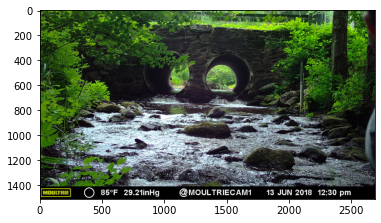

flow: 3.3499999046325684 cfs


In [19]:
img = read_image(os.path.join(img_dir, df['filename'][0]))
print(f"shape: {img.shape}")
plt.imshow(img.permute(1, 2, 0)) # move channels to last dim for plotting
plt.show()
print(f"flow: {df['flow_cfs'][0]} cfs")

## Split dataset

In [20]:
df_train, df_test = train_test_split(df, test_size=0.2)
print(f'rows \n  train: {len(df_train)}\n  test:  {len(df_test)}')

rows 
  train: 102
  test:  26


In [21]:
class FlowPhotoDataset(Dataset):
    def __init__(self, table, img_dir, col_filename='filename', col_label='flow_cfs', transform=None, label_transform=None):
        self.table = table # dataframe with columns [col_filename, col_label]
        self.img_dir = img_dir # directory of images
        self.col_filename = col_filename
        self.col_label = col_label
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.table) # no. rows in csv file

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.table.iloc[idx][self.col_filename]) # path to image
        image = read_image(img_path) # read image file as tensor
        image = image / 255.0 # convert to float in [0,1]
        
        label = self.table.iloc[idx][self.col_label] # get label from table
        if self.transform:
            image = self.transform(image) # transform image
        if self.label_transform:
            label = self.label_transform(label) # transform label
        return image, label

shape: torch.Size([3, 384, 682])


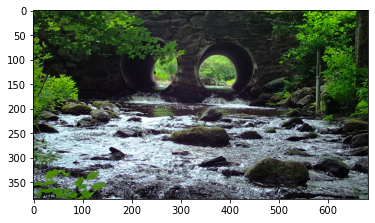

In [22]:
# transform
aspect = img.shape[2] / img.shape[1]
transform = Compose([Resize([480,np.int32(480 * aspect)]), CenterCrop([384,np.int32(384 * aspect)])])
img_transform = transform(img)
print(f"shape: {img_transform.shape}")
plt.imshow(img_transform.permute(1, 2, 0))
plt.show()

In [23]:
train_dataset = FlowPhotoDataset(df_train, img_dir, transform=transform, label_transform=Lambda(lambda y: np.log(y)))

shape: torch.Size([3, 384, 682])


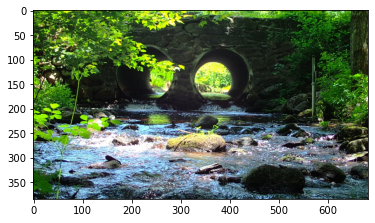

label: 1.3244189023971558


In [38]:
img, label = train_dataset[0]
print(f"shape: {img.shape}")
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"label: {label}")

shape: torch.Size([3, 384, 682])


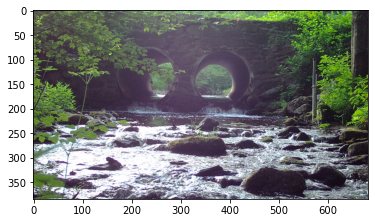

label: 1.2089602947235107


In [25]:
test_dataset = FlowPhotoDataset(df_test, img_dir, transform=transform, label_transform=Lambda(lambda y: np.log(y)))

img, label = test_dataset[0]
print(f"shape: {img.shape}")
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"label: {label}")

# Data Loaders

In [26]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

shape: torch.Size([3, 384, 682])


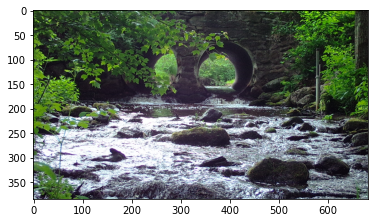

label: 1.3787660598754883


In [27]:
train_imgs, train_labels = next(iter(train_dataloader))
img = train_imgs[0]
label = train_labels[0]
print(f"shape: {img.shape}")
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"label: {label}")

# Model

In [29]:
def get_output_shape(model, input_shape=(1,3,224,224)):
    x = torch.randn(*input_shape)
    out = model(x)
    return out.shape

class ResNet18(nn.Module):
    """PyTorch ResNet-18 architecture.
    Attributes:
        pretrained (bool): whether to use weights from network trained on ImageNet
        truncate (int): how many layers to remove from the end of the network
    """
    def __init__(self, truncate=0):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        if truncate > 0:
            self.model = nn.Sequential(*list(self.model.children())[:-truncate])

        self.model.eval()

    def forward(self, x):
        x = self.model(x)
        return x

class FlowPhotoRegressionModel(nn.Module):
    def __init__(self, input_shape=(3, 384, 682), truncate=2, num_hlayers=[256, 64]):
        super(FlowPhotoRegressionModel, self).__init__()
        self.input_shape = input_shape
        self.input_nchannels = input_shape[0]
        self.input_height = input_shape[1]
        self.input_width = input_shape[2]
        
        self.resnetbody = ResNet18(truncate=truncate)
        num_filters = get_output_shape(self.resnetbody, input_shape=(1,*input_shape))[1]
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fclayer_modules = [nn.Linear(num_filters, num_hlayers[0]), nn.ReLU()]
        for i in range(1, len(num_hlayers)):
            self.fclayer_modules.extend([nn.Linear(num_hlayers[i-1], num_hlayers[i]), nn.ReLU()])
        self.fclayer_modules.extend([nn.Linear(num_hlayers[-1], 1)])
        self.fclayers = nn.Sequential(*self.fclayer_modules)
        self.freeze_resnet()
    
    def freeze_resnet(self, freeze = True):
        for p in list(self.children())[0].parameters():
            p.requires_grad = not freeze
    
    def forward(self, x):
        x = self.resnetbody(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fclayers(x)
        x = x.squeeze()
        return x

model = FlowPhotoRegressionModel(input_shape=(3, 384, 682), truncate=2)
model.to(device)
model

FlowPhotoRegressionModel(
  (resnetbody): ResNet18(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

# Optimizer

In [30]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# Train

In [225]:
X, y = next(iter(train_dataloader))
print(f"shape: {X.shape}")
pred = model(X[[0]])
print(f"pred: {pred}")
loss = loss_fn(pred, y[0])
print(f"loss: {loss}")

shape: torch.Size([64, 3, 384, 682])
pred: -0.03296898305416107
loss: 1.5423883199691772


In [226]:
def train(dataloader, model, loss_fn, optimizer, device):
    print(":Train:")
    num_batches = len(dataloader)
    total_loss = 0
    
    for batch, (X, y) in tqdm(enumerate(dataloader), total=num_batches):
        X = X.to(device)
        y = y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 1 == 0:
            print(f"  loss(batch): {loss.item():>7f} [{(batch + 1):>5d}/{num_batches:>5d}]")
    print(f"  ---------------------\n  loss(avg): {(total_loss / num_batches):>8f}\n")

def test(dataloader, model, loss_fn):
    print(":Test:")
    num_batches = len(dataloader)
    total_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
    print(f"  loss(avg): {(total_loss / num_batches):>8f}\n")


In [228]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}\n--------------------------")
    train(train_dataloader, model, loss_fn, optimizer, device)
    test(test_dataloader, model, loss_fn)
    
    if (epoch+1) == unfreeze_after:
        print('\n:Model:\n  unfreeze resnet\n\n')
        model.freeze_resnet(False)
        
print("done")

Epoch 1/3
--------------------------
:Train:


  0%|          | 0/2 [00:00<?, ?it/s]

  loss(batch): 1.558106 [    1/    2]
  loss(batch): 1.334283 [    2/    2]
  ---------------------
  loss(avg): 1.446194

:Test:
  loss(avg): 1.176290

Epoch 2/3
--------------------------
:Train:


  0%|          | 0/2 [00:00<?, ?it/s]

  loss(batch): 1.099480 [    1/    2]
  loss(batch): 0.740226 [    2/    2]
  ---------------------
  loss(avg): 0.919853

:Test:
  loss(avg): 0.655329



  model: unfreeze resnet


Epoch 3/3
--------------------------
:Train:


  0%|          | 0/2 [00:00<?, ?it/s]

  loss(batch): 0.501446 [    1/    2]
  loss(batch): 0.232409 [    2/    2]
  ---------------------
  loss(avg): 0.366927

:Test:
  loss(avg): 0.113375

done
